#  Sequence to Sequence with Attention
In this project we will be teaching a neural network to translate from
French to English.

This is made possible by the simple but powerful idea of the [sequence
to sequence network](https://arxiv.org/abs/1409.3215>), in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

To improve upon this model we'll use an [attention
mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder
learn to focus over a specific range of the input sequence.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
%matplotlib inline

## Preparing Data
The data for this project is a set of many thousands of English to
French translation pairs.

In [2]:
def download_dataset():
    ! wget https://download.pytorch.org/tutorial/data.zip
    ! unzip data.zip

In [3]:
# wget https://www.manythings.org/anki/spa-eng.zip
# mv _about.txt spa.txt data

In [4]:
# to download the dataset
#download_dataset()

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.

In [5]:
SOS_token = 1
EOS_token = 2
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"PAD": 0, "SOS": 1, "EOS": 2, "UNK": 3}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3: "UNK"}
        self.n_words = 4  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [6]:
def unicodeToAscii(s):
    """Turn a Unicode string to plain ASCII
    
    https://stackoverflow.com/a/518232/2809427
    """
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    """Lowercase, trim, and remove non-letter characters"""
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [7]:
def readLangs(filename):
    # Read the file and split into lines
    lines = open(filename).read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    return pairs

In [8]:
MAX_LENGTH = 15

# Selecting some sentences
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# Filtering by sentence length
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs

In [9]:
def prepareData(data_filename):
    pairs = readLangs(data_filename)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    
    #randomize the data with a fixed seed for repeatability
    random.seed(4)
    random.shuffle(pairs)
    #choose the first 10 pairs for testing and the rest for training
    valid_pairs = pairs[0:300]
    train_pairs = pairs[300:len(pairs)]
    
    print("number of valid pairs: %s" % len(valid_pairs))
    print("number of train pairs: %s" % len(train_pairs))
    
    input_lang = Lang("english")
    output_lang = Lang("french")
    
    print("Counting words...")
    cnt = 0
    for pair in pairs:
        input_lang.addSentence(pair[1])
        output_lang.addSentence(pair[0])
        
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs, train_pairs, valid_pairs

In [10]:
input_lang, output_lang, pairs, train_pairs, valid_pairs = prepareData("data/eng-fra.txt")
random.seed(4)
print(random.choice(pairs))

Read 135842 sentence pairs
Trimmed to 12823 sentence pairs
number of valid pairs: 300
number of train pairs: 12523
Counting words...
Counted words:
english 5036
french 3310
['we re still vulnerable .', 'nous sommes encore vulnerables .']


In [11]:
train_pairs[0]

['i m no liar .', 'je ne suis pas un menteur .']

## Dataset

In [12]:
def encode_sentence(s, vocab2index, N=MAX_LENGTH+2, padding_start=True):
    enc = np.zeros(N, dtype=np.int32)
    enc1 = np.array([SOS_token] + [vocab2index.get(w, vocab2index["UNK"]) for w in s.split()] + [EOS_token])
    l = min(N, len(enc1))
    if padding_start:
        enc[:l] = enc1[:l]
    else:
        enc[N-l:] = enc1[:l]
    return enc, l

In [13]:
train_pairs[0]

['i m no liar .', 'je ne suis pas un menteur .']

In [14]:
encode_sentence(train_pairs[0][0], input_lang.word2index, padding_start=False)

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   3, 170,
          3,   3,  11,   2], dtype=int32), 7)

In [15]:
encode_sentence(train_pairs[0][1], output_lang.word2index)

(array([ 1,  3,  3,  3,  3,  3,  3, 10,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       dtype=int32), 9)

In [16]:
class PairDataset(Dataset):
    def __init__(self, pairs, input_lang, output_lang):
        self.pairs = pairs
        self.input_word2index = input_lang.word2index
        self.output_word2index = output_lang.word2index
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        x, n_x = encode_sentence(self.pairs[idx][1], self.input_word2index, padding_start=False)
        y, n_y = encode_sentence(self.pairs[idx][0], self.output_word2index)
        return x, y
    
train_ds = PairDataset(train_pairs, input_lang, output_lang)
valid_ds = PairDataset(valid_pairs, input_lang, output_lang)

In [17]:
train_ds[0]

(array([  0,   0,   0,   0,   0,   0,   0,   0,   1,   4,  58,   5,  60,
          7, 424,  11,   2], dtype=int32),
 array([  1,   4,   5, 193, 258,  10,   2,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0], dtype=int32))

In [18]:
batch_size=5
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

## The Seq2Seq Model

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A Sequence to Sequence network <https://arxiv.org/abs/1409.3215>, or
seq2seq network, or Encoder Decoder network <https://arxiv.org/pdf/1406.1078v3.pdf>, is a model consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

### The Encoder
The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

![](imgs/encoder-network.png)

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=0)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        output, hidden = self.gru(x)
        return output, hidden

In [20]:
x, y = next(iter(train_dl))

In [21]:
x, y

(tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,
            96,   97, 2200,   11,    2],
         [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,
            40,   41, 1110,   11,    2],
         [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    4,
            85,  199,  174,   11,    2],
         [   0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    4,  260,
           189,  154,  790,   11,    2],
         [   0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    4,    5,
            68,    9,  974,   11,    2]], dtype=torch.int32),
 tensor([[   1,   80,   12,  815,   19, 1224, 1686,   10,    2,    0,    0,    0,
             0,    0,    0,    0,    0],
         [   1,   11,   12,  257,   10,    2,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0],
         [   1,    4,    5, 1101,   10,    2,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,   

In [22]:
input_size = input_lang.n_words
hidden_size = 2
encoder = EncoderRNN(input_size, hidden_size)

In [23]:
enc_outputs, enc_hidden = encoder(x.long())

In [24]:
enc_outputs.shape, enc_hidden.shape

(torch.Size([5, 17, 2]), torch.Size([1, 5, 2]))

The Attention Decoder
-----------

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

In [25]:
class AttnDotDecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size, max_length=MAX_LENGTH):
        super(AttnDotDecoderRNN, self).__init__()

        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=0)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(0.5)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_step, last_hidden, enc_outputs):
        embedded = self.embedding(input_step)
        embedded = self.dropout(embedded)

        _, hidden = self.gru(embedded, last_hidden)
        
        # Calculate attention weights from the current GRU hidden
        attention_scores = torch.einsum('ijk,ik->ij', [enc_outputs, hidden[-1]])
        attn_weights = F.softmax(attention_scores, dim=1)    
        
        # apply attention to enc_outputs
        attn_applied = torch.einsum('ijk,ij->ik', [enc_outputs, attn_weights])
        
        concat_input = torch.cat((hidden[-1], attn_applied), 1) 
        concat_output = F.relu(self.attn_combine(concat_input))
        output = self.out(concat_output)

        return output, hidden, attn_weights

In [26]:
output_size = output_lang.n_words
hidden_size = 2

In [27]:
embedding = nn.Embedding(output_size, hidden_size)
attn = nn.Linear(hidden_size * 2, 1)
attn_combine = nn.Linear(hidden_size * 2, hidden_size)
dropout = nn.Dropout(0.1)
gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
out = nn.Linear(hidden_size, output_size)

In [28]:
y[:,0].shape

torch.Size([5])

In [29]:
batch_size = y.size(0)
decoder_input = SOS_token*torch.ones(batch_size,1)
decoder_input.shape

torch.Size([5, 1])

In [30]:
hidden = enc_hidden
xx = decoder_input
xx = embedding(xx.long())
output, hidden = gru(xx, hidden)

In [31]:
output

tensor([[[ 0.0896, -0.1332]],

        [[ 0.0699, -0.1621]],

        [[ 0.0260, -0.3900]],

        [[-0.0061, -0.3986]],

        [[ 0.0385, -0.3890]]], grad_fn=<TransposeBackward0>)

In [32]:
hidden

tensor([[[ 0.0896, -0.1332],
         [ 0.0699, -0.1621],
         [ 0.0260, -0.3900],
         [-0.0061, -0.3986],
         [ 0.0385, -0.3890]]], grad_fn=<StackBackward>)

In [33]:
enc_length = 17
attention_scores = torch.zeros(batch_size, enc_length)
for ei in range(enc_length):
    attention_scores[:, ei] = (enc_outputs[:, ei, :]*hidden[-1]).sum(1)

In [34]:
c = torch.einsum('ijk,ik->ij', [enc_outputs, hidden[-1]])
c.shape

torch.Size([5, 17])

In [35]:
(attention_scores==c).all()

tensor(1, dtype=torch.uint8)

In [36]:
attn_weights = F.softmax(attention_scores, dim=1)
attn_weights.shape

torch.Size([5, 17])

In [37]:
attn_weights.shape

torch.Size([5, 17])

In [38]:
enc_outputs.shape

torch.Size([5, 17, 2])

In [39]:
attention_scores = torch.einsum('ijk,ik->ij', [enc_outputs, hidden[-1]])
attn_weights = F.softmax(attention_scores, dim=1)    
        
attn_applied = torch.einsum('ijk,ij->ik', [enc_outputs, attn_weights])

In [40]:
attn_applied2 = torch.zeros(batch_size, enc_length, hidden_size)
for ei in range(hidden_size):
    attn_applied2[:,:, ei] = enc_outputs[:,:,ei]*attn_weights

In [41]:
attn_applied2.sum(1) 

tensor([[0.2590, 0.1943],
        [0.2710, 0.1241],
        [0.1770, 0.1656],
        [0.1949, 0.1593],
        [0.1991, 0.0126]], grad_fn=<SumBackward2>)

In [42]:
attn_applied

tensor([[0.2590, 0.1943],
        [0.2710, 0.1241],
        [0.1770, 0.1656],
        [0.1949, 0.1593],
        [0.1991, 0.0126]], grad_fn=<AsStridedBackward>)

In [43]:
enc_outputs.shape, attn_weights.unsqueeze(2).shape

(torch.Size([5, 17, 2]), torch.Size([5, 17, 1]))

In [44]:
torch.matmul(attn_weights.unsqueeze(1), enc_outputs).squeeze(1)

tensor([[0.2590, 0.1943],
        [0.2710, 0.1241],
        [0.1770, 0.1656],
        [0.1949, 0.1593],
        [0.1991, 0.0126]], grad_fn=<SqueezeBackward1>)

In [45]:
concat_input = torch.cat((hidden[-1], attn_applied), 1) 
concat_input.shape

torch.Size([5, 4])

In [46]:
concat_output = F.relu(attn_combine(concat_input))
output = out(concat_output)

In [47]:
# testing the whole thing
batch_size = y.size(0)
decoder_input = SOS_token*torch.ones(batch_size,1).long()
decoder = AttnDotDecoderRNN(output_size, hidden_size)

In [48]:
output, hidden, attn_weights = decoder(decoder_input, hidden, enc_outputs)

Training
========

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

**Teacher forcing** is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.

In [49]:
def train_batch(x, y, encoder, decoder, encoder_optimizer, decoder_optimizer,
                teacher_forcing_ratio=0.5):

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    batch_size = y.size(0)
    target_length = y.size(1)

    enc_outputs, enc_hidden = encoder(x)

    loss = 0
    dec_input = y[:,0].unsqueeze(1) # allways SOS
    hidden = enc_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(1, target_length):
        output, hidden, attention = decoder(dec_input, hidden, enc_outputs)
        yi =  y[:, di]
        if (yi>0).sum() > 0:
            loss += F.cross_entropy(
                output, yi, ignore_index = 0, reduction="sum")/(yi>0).sum()
        if use_teacher_forcing:
            dec_input = y[:, di].unsqueeze(1)  # Teacher forcing: Feed the target
                                               # as the next input
        else:                
            dec_input = output.argmax(dim=1).unsqueeze(1).detach() # Feeds predictions

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()

In [50]:
def train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 10,
          teacher_forcing_ratio=0.5):
    for i in range(epochs):
        total_loss = 0
        total = 0
        encoder.train()
        decoder.train()
        for x, y in train_dl:
            x = x.long().cuda()
            y = y.long().cuda()
            loss = train_batch(x, y, encoder, decoder, enc_optimizer, dec_optimizer,
                               teacher_forcing_ratio)
            total_loss = loss*x.size(0)
            total += x.size(0)
        if i % 10 == 0:
            print("train loss %.3f" % (total_loss / total))   

In [51]:
input_size = input_lang.n_words
output_size = output_lang.n_words
hidden_size = 300
encoder = EncoderRNN(input_size, hidden_size).cuda()
decoder = AttnDotDecoderRNN(output_size, hidden_size).cuda()
enc_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
dec_optimizer = optim.Adam(decoder.parameters(), lr=0.001) 

In [52]:
batch_size= 1000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [53]:
train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 100)

train loss 2.821
train loss 1.706
train loss 1.376
train loss 1.241
train loss 0.774
train loss 0.526
train loss 0.464
train loss 0.414
train loss 0.679
train loss 0.301


In [54]:
enc_optimizer = optim.Adam(encoder.parameters(), lr=0.0001)
dec_optimizer = optim.Adam(decoder.parameters(), lr=0.0001) 
train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 100)

train loss 0.435
train loss 0.225
train loss 0.217
train loss 0.199
train loss 0.201
train loss 0.446
train loss 0.192
train loss 0.191
train loss 0.187
train loss 0.177


In [55]:
train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 300, teacher_forcing_ratio=0.0)

train loss 0.375
train loss 0.311
train loss 0.276
train loss 0.298
train loss 0.300
train loss 0.308
train loss 0.368
train loss 0.298
train loss 0.286
train loss 0.268
train loss 0.304
train loss 0.286
train loss 0.238
train loss 0.259
train loss 0.236
train loss 0.254
train loss 0.226
train loss 0.226
train loss 0.211
train loss 0.232
train loss 0.198
train loss 0.195
train loss 0.207
train loss 0.212
train loss 0.229
train loss 0.214
train loss 0.195
train loss 0.184
train loss 0.205
train loss 0.197


In [56]:
train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 300, teacher_forcing_ratio=0.0)

train loss 0.185
train loss 0.168
train loss 0.172
train loss 0.169
train loss 0.154
train loss 0.194
train loss 0.167
train loss 0.168
train loss 0.167
train loss 0.166
train loss 0.146
train loss 0.167
train loss 0.147
train loss 0.135
train loss 0.144
train loss 0.143
train loss 0.137
train loss 0.162
train loss 0.155
train loss 0.123
train loss 0.125
train loss 0.140
train loss 0.125
train loss 0.127
train loss 0.152
train loss 0.116
train loss 0.126
train loss 0.104
train loss 0.124
train loss 0.093


In [109]:
#train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 300, teacher_forcing_ratio=0.0)

## Visualizing Attention

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

In [57]:
def showAttention(x, y_hat, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + x + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + y_hat + ['<EOS>'])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [58]:
batch_size=5
train_dl_2 = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

x, y = next(iter(train_dl_2)) 
x = x.long().cuda()
y = y.long().cuda()

In [59]:
decoder = decoder.eval()
encoder = encoder.eval()
batch_size = x.size(0)
enc_outputs, enc_hidden = encoder(x)
dec_input = SOS_token*torch.ones(batch_size, 1).long().cuda()  # SOS
hidden = enc_hidden

output, hidden, attention = decoder(dec_input, hidden, enc_outputs)

In [60]:
x

tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,   12,
         1164,   70,  389,   11,    2],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    1,  100,   41,
            7,  308, 3299,   11,    2],
        [   0,    0,    0,    0,    0,    0,    0,    1,   76,   52,  287, 4068,
          114,   29,  253,   11,    2],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    1,   12,   92,
           13,   60,  341,   11,    2],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    1,  137,   68,
          160,   70, 4098,   11,    2]], device='cuda:0')

In [61]:
attention

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5414e-44,
         8.4078e-45, 2.8026e-45, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.4953e-36,
         2.2014e-32, 6.5652e-27, 2.6242e-22, 4.6063e-14, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4307e-40, 8.9502e-32,
         1.6383e-29, 3.2395e-22, 3.4510e-20, 4.6423e-11, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.4055e-41, 1.6942e-41, 6.4652e-33, 4.7534e-27,
         2.6277e-24, 5.3554e-24, 2.9888e-21, 1.3025e-11, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8900e-35, 5.9183e-31,
         2.1709e-25, 1.5606e-20, 6.7266e-17, 2.7531e-12, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.6434e-44, 4.7

In [62]:
output.shape

torch.Size([5, 3310])

In [63]:
hidden.shape

torch.Size([1, 5, 300])

## Evaluation

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.

In [64]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [65]:
def decoding(x, y, encoder, decoder, max_length=MAX_LENGTH+2):
    decoder = decoder.eval()
    encoder = encoder.eval()
    loss = 0 
    with torch.no_grad():
        batch_size = x.size(0)
        enc_outputs, enc_hidden = encoder(x)
        dec_input = SOS_token*torch.ones(batch_size, 1).long().cuda()  # SOS
        hidden = enc_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(batch_size, max_length, max_length)

        for di in range(1, max_length):
            output, hidden, attention = decoder(dec_input, hidden, enc_outputs)
            decoder_attentions[:, di, :] = attention.detach()
            pred = output.argmax(dim=1)
            yi =  y[:, di]
            if (yi>0).sum() > 0:
                loss += F.cross_entropy(
                    output, yi, ignore_index = 0, reduction="sum")/(yi>0).sum()
            decoded_words.append(pred.cpu().numpy())
            dec_input = output.argmax(dim=1).unsqueeze(1).detach()

        return loss/batch_size, np.transpose(decoded_words), decoder_attentions

In [66]:
def print_results(x, y, encoder, decoder, attention=False, max_length=MAX_LENGTH+2):
    loss, decoded_words, attentions = decoding(x, y, encoder, decoder)
    for i in range(x.shape[0]):
        xi = x[i].cpu().numpy()
        yi = y[i].cpu().numpy()
        y_hat = decoded_words[i]
        x_sent = [input_lang.index2word[t] for t in xi if t > 3]
        y_sent = [output_lang.index2word[t] for t in yi if t > 3]
        y_hat_sent = [output_lang.index2word[t] for t in y_hat if t > 3]
        print('>', ' '.join(x_sent))
        print('=', ' '.join(y_sent))
        print('<', ' '.join(y_hat_sent))
        print('')
        attns = attentions[i,:len(y_hat_sent)+1:,max_length-len(x_sent)-1:]
        if attention:
            showAttention(x_sent, y_hat_sent, attns)

In [67]:
batch_size=300
valid_dl_2 = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

x, y = next(iter(valid_dl_2)) 
x = x.long().cuda()
y = y.long().cuda()

loss, decoded_words, attentions = decoding(x, y, encoder, decoder)
loss

tensor(0.1794, device='cuda:0')

In [68]:
batch_size=10
train_dl_2 = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

x, y = next(iter(train_dl_2)) 
x = x.long().cuda()
y = y.long().cuda()

In [69]:
print_results(x, y, encoder, decoder)

> je suis en route pour retourner en ville .
= i m headed back into town .
< i m headed back into town .

> c est un voleur .
= he is a thief .
< he is a thief .

> tu as raison je pense .
= you re right i think .
< you re right i think .

> je ne suis pas joueuse .
= i m not a gambler .
< i m not a gambler .

> je suis votre amie .
= i m your friend .
< i m your friend .

> je suis fatigue d avoir des horaires de travail neuf heures cinq heures .
= i m tired of working a nine to five job .
< i m tired of working a nine to five job .

> nous ne sommes pas a la maison .
= we re not home .
< we re not home .

> je suis ici pour faire ce que je peux .
= i m here to do what i can .
< i m here to do what i can .

> j en suis vraiment fiere .
= i m really proud of this .
< i m really proud of this .

> il quitte narita pour hawaii ce soir .
= he is leaving narita for hawaii this evening .
< he is leaving narita for hawaii this evening .



In [70]:
batch_size=10
valid_dl_2 = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

x, y = next(iter(valid_dl_2)) 
x = x.long().cuda()
y = y.long().cuda()

In [71]:
print_results(x, y, encoder, decoder)

> j en ai plus qu assez de toutes tes recriminations .
= i m getting sick and tired of all your complaints .
< i m sick of your your your hair .

> ce sont des illets .
= they re carnations .
< they re animals .

> je suis certaine que mes parents ne me laisseront pas y aller seule .
= i m sure my parents won t let me go by myself .
< i m sure my parents won t let me go by myself .

> il a de la chance d avoir une si bonne epouse .
= he is fortunate having such a good wife .
< he is had that a serious great great a .

> j en ai fini avec mon travail .
= i am through with my work .
< i m through with my work .

> nous ne sommes pas apparentes .
= we re unrelated .
< we re not related .

> desole j ai perdu mon sang froid .
= i m sorry i lost my temper .
< i m sorry i last my eat .

> je suis heureuse de vous avoir invite .
= i m glad i invited you .
< i m glad i invited you .

> tu ne pretes meme pas attention .
= you re not even paying attention .
< you re not even paying attention .



> j en ai plus qu assez de toutes tes recriminations .
= i m getting sick and tired of all your complaints .
< i m sick of your your your hair .



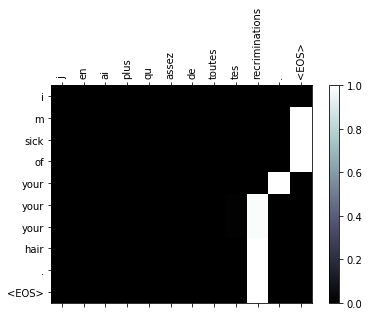

> ce sont des illets .
= they re carnations .
< they re animals .



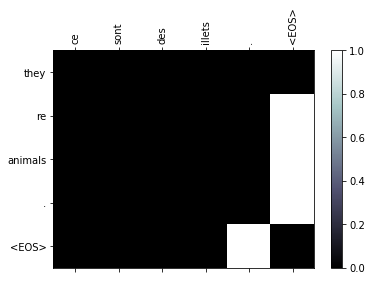

> je suis certaine que mes parents ne me laisseront pas y aller seule .
= i m sure my parents won t let me go by myself .
< i m sure my parents won t let me go by myself .



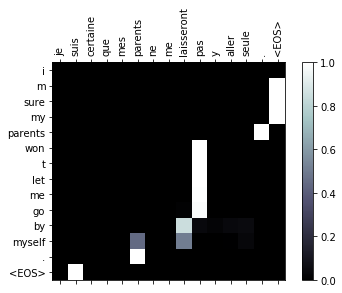

> il a de la chance d avoir une si bonne epouse .
= he is fortunate having such a good wife .
< he is had that a serious great great a .



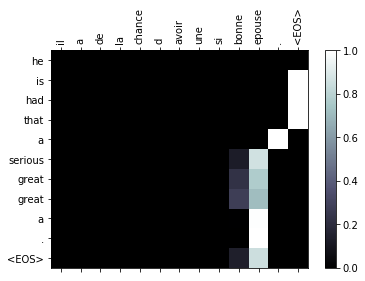

> j en ai fini avec mon travail .
= i am through with my work .
< i m through with my work .



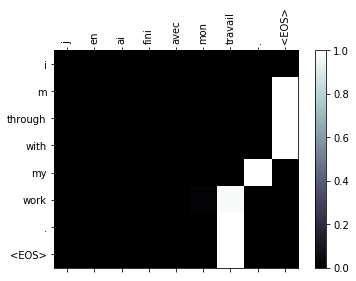

> nous ne sommes pas apparentes .
= we re unrelated .
< we re not related .



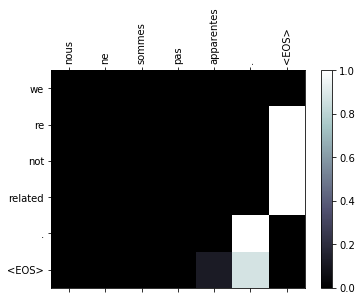

> desole j ai perdu mon sang froid .
= i m sorry i lost my temper .
< i m sorry i last my eat .



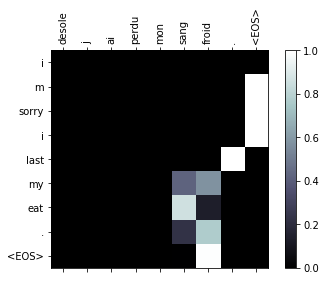

> je suis heureuse de vous avoir invite .
= i m glad i invited you .
< i m glad i invited you .



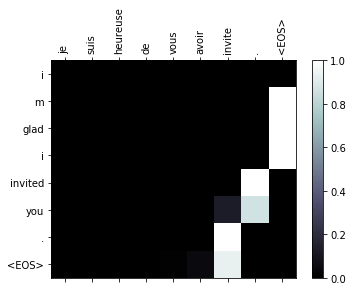

> tu ne pretes meme pas attention .
= you re not even paying attention .
< you re not even paying attention .



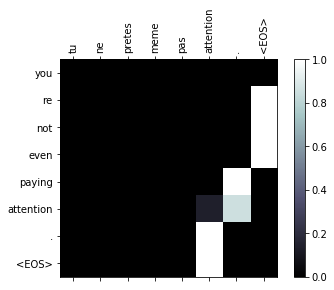

> je suis un etre mauvais .
= i am a bad person .
< i m a bit drunk .



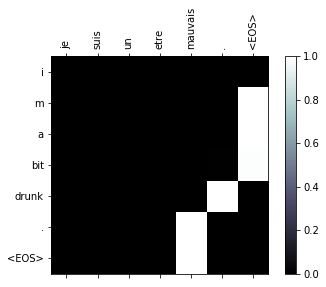

In [72]:
print_results(x, y, encoder, decoder, attention=True)

Exercises
=========
-  Replace the embeddings with pre-trained word embeddings. Here are word embeddings for various languages.

https://fasttext.cc/docs/en/crawl-vectors.html 



# Credits
The original notebook was written by Sean Robertson <https://github.com/spro/practical-pytorch>_